---

<h1> <center> ProjectOAK </center> </h1>  

<h3> <center> By Sam Evans and Maria Yampolskaya </center> </h3>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

try:
    import QOL.plots as pqol #custom plotting stuff for Sam
    pqol.fixfigsize((1,1))
    pqol.scale_fonts((2,2))
except:
    print('pqol not loaded, defaulting to matplotlib.pyplot.')
    pqol=plt

import ImageProcessing as ip #ProjectOAK file with image processing functions.
import  DataProcessing as dp #ProjectOAK file with data  processing functions.
#''' #comment this line if actively editting ImageProcessing.py, to force reloads.
from importlib import reload 
reload(ip)
reload(dp)
#''';

<module 'DataProcessing' from '/Users/Sevans/Python/ProjectOAK/DataProcessing.py'>

---
<h2> <center> Load the Pokémon Data! </center> </h2>  

---

In [2]:
## get data from csv file about pokemon.
csvdata, cc = dp.read_csv(dp.CSVFILE2)

Took  0.02 seconds to read data from dataset/Pokedex_Ver6.csv


## Get images from `IMAGESFOLDER2J`.
(this is the bigger dataset with ~800 256x256x3 images)  
(J is for jpg)

In [3]:
allimages2 = ip.get_all_images(dp.IMAGESFOLDER2J)

got all 819 images in   2.3 seconds (from folder = dataset/images/archive/pokemon_jpg/pokemon_jpg)


In [4]:
imagekeys2   = np.array(list(allimages2.keys()))
seris2       = np.array(dp.Ns_to_S(imagekeys2, csvdata, code=1))    #serial numbers
idx_include2 = (seris2 != '')
used_images2 = np.array([allimages2[key] for key in imagekeys2[idx_include2]])
used_rows2   = np.array(dp.vectorized_row_where(seris2[idx_include2], csvdata, cc.SERIAL))
used_types2  = csvdata[used_rows2, cc.TYPE1]
used_labels2 = dp.type_to_idx(used_types2)

## Next get images from `IMAGESFOLDER1J`.
(this is the dataset we started with originally)

In [5]:
allimages1   = ip.get_all_images(dp.IMAGESFOLDER1J)
imagekeys1   = np.array(list(allimages1.keys()))
imagekeys_title1 = np.array([key.title() for key in imagekeys1])
seris1       = np.array(dp.pokes_to_S(imagekeys_title1, csvdata))    #serial numbers
idx_include1 = (seris1 != '')
used_images1 = np.array([allimages1[key] for key in imagekeys1[idx_include1]])
resized_images1 = np.array([np.array(ip.array_to_PIL(img).resize((256, 256))) for img in used_images1])
used_rows1   = np.array(dp.vectorized_row_where(seris1[idx_include1], csvdata, cc.SERIAL))
used_types1  = csvdata[used_rows1, cc.TYPE1]
used_labels1 = dp.type_to_idx(used_types1)

got all 809 images in  0.96 seconds (from folder = dataset/images/image_jpgs)


## Compile data into single place for convenience

In [6]:
used_rows_compiled   = np.append(used_rows2, used_rows1)
used_images_compiled = np.append(used_images2, resized_images1, axis=0)
used_labels_compiled = np.append(used_labels2, used_labels1)
print(used_images_compiled.shape)

(1478, 256, 256, 3)


## Create dataset class object.
Note that `do_scaling=False` is fine if we are using data augmentation with `featurewise_center=True, featurewise_std_normalization=True`.

In [7]:
## make dataset with COMPILED DATA (USES BOTH SETS OF IMAGES)
# TODO: be careful about how we split the pokemon so we dont have image of same pokemon in train and test.
# (until we do that, ignore this cell - dd is overwritten by the next cell)
identifiers = csvdata[used_rows_compiled][:,[cc.NAME, cc.SERIAL]]
dd = dp.Full_Dataset(used_images_compiled, used_labels_compiled, serials=identifiers, val_size=0.2, do_scaling=False)

print('train_size: ', dd.train_size, ', val_size: ', dd.val_size, ', test_size: ', dd.test_size, sep='')

| setting: train_data     | setting: val_data       | setting: test_data      
| setting: train_labels   | setting: val_labels     | setting: test_labels    
| setting: train_serials  | setting: val_serials    | setting: test_serials   
train_size: 1036, val_size: 295, test_size: 147


In [8]:
## make dataset with only stuff from IMAGESFOLDER2J
identifiers = csvdata[used_rows2][:,[cc.NAME, cc.TYPE1, cc.TYPE2]]
dd = dp.Full_Dataset(used_images2, used_labels2, serials=identifiers, val_size=0.2, do_scaling=False)

#use this line for scaling:
#dd = dp.Full_Dataset(used_images2/255., used_labels2, serials=identifiers, val_size=0.2, do_scaling=False)

print('train_size: ', dd.train_size, ', val_size: ', dd.val_size, ', test_size: ', dd.test_size, sep='')

| setting: train_data     | setting: val_data       | setting: test_data      
| setting: train_labels   | setting: val_labels     | setting: test_labels    
| setting: train_serials  | setting: val_serials    | setting: test_serials   
train_size: 493, val_size: 140, test_size: 70


In [9]:
## weight classes to counteract data imbalance (this can be turned on or off later).
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=dp.type_to_idx(dp.ALLTYPES[:-1]), y=dd.train_labels)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 0.5706018518518519, 1: 1.7118055555555556, 2: 1.3042328042328042, 3: 1.0955555555555556, 4: 1.9563492063492063, 5: 1.6111111111111112, 6: 0.9444444444444444, 7: 13.694444444444445, 8: 1.9563492063492063, 9: 0.6680216802168022, 10: 1.3694444444444445, 11: 2.106837606837607, 12: 0.39126984126984127, 13: 1.3694444444444445, 14: 0.912962962962963, 15: 0.9444444444444444, 16: 1.3694444444444445, 17: 0.4279513888888889}


In [10]:
## here is a version of the dataset which we scale by feature-wise means & stddevs
identifiers = csvdata[used_rows2][:,[cc.NAME, cc.TYPE1, cc.TYPE2, cc.SERIAL]]
sdd = dp.Full_Dataset(used_images2, used_labels2, serials=identifiers, val_size=0.2, test_size=0.1, do_scaling=True)

print('train_size: ', dd.train_size, ', val_size: ', dd.val_size, ', test_size: ', dd.test_size, sep='')

| setting: train_data     | setting: val_data       | setting: test_data      
| setting: train_labels   | setting: val_labels     | setting: test_labels    
| setting: train_serials  | setting: val_serials    | setting: test_serials   
scaling data
Took  7.62 seconds to scale data
train_size: 493, val_size: 140, test_size: 70


In [11]:
## weight classes to counteract data imbalance (this can be turned on or off later).
from sklearn.utils import class_weight
sclass_weights = class_weight.compute_class_weight('balanced', classes=dp.type_to_idx(dp.ALLTYPES[:-1]), y=sdd.train_labels)
sclass_weight_dict = dict(enumerate(class_weights))

In [12]:
#read image shape
IMAGESHAPE = dd.train_data[0].shape
print("shape of images:",IMAGESHAPE)

shape of images: (256, 256, 3)


---
<h2> <center> A Wild Neural Network Appears! </center> </h2>  

---

## Single-type classification (the simplest problem)

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

### Set Up Data Augmentation

In [14]:
## SET UP DATA AUGMENTATION
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,              #center features at 0.
    featurewise_std_normalization=True,   #divide by each feature's std.
    #rescale = 1/255.,
    #rotation_range=45,       #rotate by up to this many degrees.
    #width_shift_range=0.2,   #shift by up to this fraction of the image, horizontally.
    #height_shift_range=0.2,  #shift by up to this fraction of the image, vertically.
    #vertical_flip=True,      #whether to sometimes flip images vertically.
    #horizontal_flip=True,    #whether to sometimes flip images horizontally.
    #zoom_range=0.2,          #zoom random within [0.8 .. 1.2]
    #shear_range=0.2,         #range for shear transformations
    #fill_mode='constant',    #fill extra pixels with constant
    #cval=255                 #constant = 255 ( --> 'white')
)
now=time.time()
datagen.fit(dd.train_data)    #fit to training data (and ONLY TRAINING DATA)
print('took {:5.2f} seconds to fit datagen.'.format(time.time()-now))

took  3.44 seconds to fit datagen.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

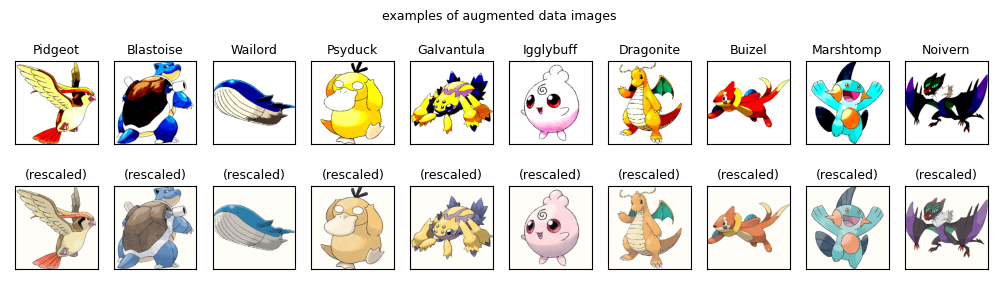

In [15]:
#datagen.flow makes an iterator which returns
#     <batch_size> manipulated images (and original labels) from the input data given to it.
#for example:
B = 10
ims, lbs = next(datagen.flow(dd.train_data, dd.train_serials[:,0], batch_size=B))
fig, axs = plt.subplots(2, B, figsize=(B,3))
plt.suptitle('examples of augmented data images')
for i in range(B):
    plt.sca(axs[0][i])
    plt.imshow(ims[i])
    plt.gca().yaxis.set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.title(str(lbs[i]))
    
    plt.sca(axs[1][i])
    ip.plt_rescaled(ims[i])
    plt.gca().yaxis.set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.title('(rescaled)')
plt.tight_layout()

### Define Network Architecture

In [16]:
def create_CNN():
    num_classes = dp.NTYPES+1

    model = models.Sequential()
    
    #parameters: layers.Conv2D(numfilters, kernel_size, strides)
    model.add(layers.Conv2D(5, 2, 1, input_shape = IMAGESHAPE))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size = (2,2)))
    
    model.add(layers.Conv2D(10, 4, 2, input_shape = IMAGESHAPE))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size = (2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes * 2, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(layers.Dense(num_classes, activation = 'softmax'))

    metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='stk1'),
               tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='stk3'),
               tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='stk5')]
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    style = dict(metrics=metrics, loss=loss)
    
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), **style)
    #model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.2, nesterov=False, name="SGD"), **style)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), **style)
    
    #
    return model

In [17]:
model = create_CNN()
#model.summary()

### Train the Network

In [18]:
epochs = 10
batch_size = 32
verbose = 1

measure = dict(monitor='stk1', mode='max')

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0, patience=50, verbose=0,
    baseline=None, restore_best_weights=True, **measure
)

# this line will SAVE the model weights to a file:
checkpointing = tf.keras.callbacks.ModelCheckpoint('model_checkpoints/myfirstmodel.h5',
    verbose=0, save_best_only=True, **measure)

callbacks = [early_stopping, checkpointing]

'''
history = model.fit(datagen.flow(dd.train_data, dd.train_labels, batch_size=batch_size),
          #          class_weight = class_weight_dict,
                    validation_data=(dd.val_data, dd.val_labels),
                    steps_per_epoch=len(dd.train_data) / batch_size, epochs=epochs,
                    callbacks = callbacks, verbose=verbose)
'''


history = model.fit(sdd.train_data, sdd.train_labels,
                    validation_data=(sdd.val_data, sdd.val_labels),
                    batch_size=batch_size,
                    class_weight = sclass_weight_dict,
                    epochs=epochs,
                    callbacks = callbacks,
                    verbose=verbose)

# train the data for 500 epochs
#model.fit(data_train, labels_train, batch_size = 32, epochs = 500, verbose=1, validation_split = 0.1)
#model.evaluate(dd['val']['data'], dd['val']['labels'])

Epoch 1/10
16/16 [==============================] - 5s 306ms/step - loss: 3.0915 - stk1: 0.0264 - stk3: 0.1501 - stk5: 0.2556 - val_loss: 3.0622 - val_stk1: 0.0143 - val_stk3: 0.1286 - val_stk5: 0.2000
Epoch 2/10
16/16 [==============================] - 6s 353ms/step - loss: 3.0788 - stk1: 0.0243 - stk3: 0.1542 - stk5: 0.2252 - val_loss: 3.0528 - val_stk1: 0.0143 - val_stk3: 0.1214 - val_stk5: 0.2000
Epoch 3/10
16/16 [==============================] - 5s 332ms/step - loss: 3.0686 - stk1: 0.0243 - stk3: 0.1440 - stk5: 0.2252 - val_loss: 3.0418 - val_stk1: 0.0143 - val_stk3: 0.1143 - val_stk5: 0.2000
Epoch 4/10
16/16 [==============================] - 4s 276ms/step - loss: 3.0577 - stk1: 0.0243 - stk3: 0.1359 - stk5: 0.2252 - val_loss: 3.0314 - val_stk1: 0.0143 - val_stk3: 0.1000 - val_stk5: 0.2000
Epoch 5/10
16/16 [==============================] - 5s 288ms/step - loss: 3.0484 - stk1: 0.0243 - stk3: 0.1156 - stk5: 0.2252 - val_loss: 3.0239 - val_stk1: 0.0143 - val_stk3: 0.0929 - val_stk

### Check network performance vs epoch

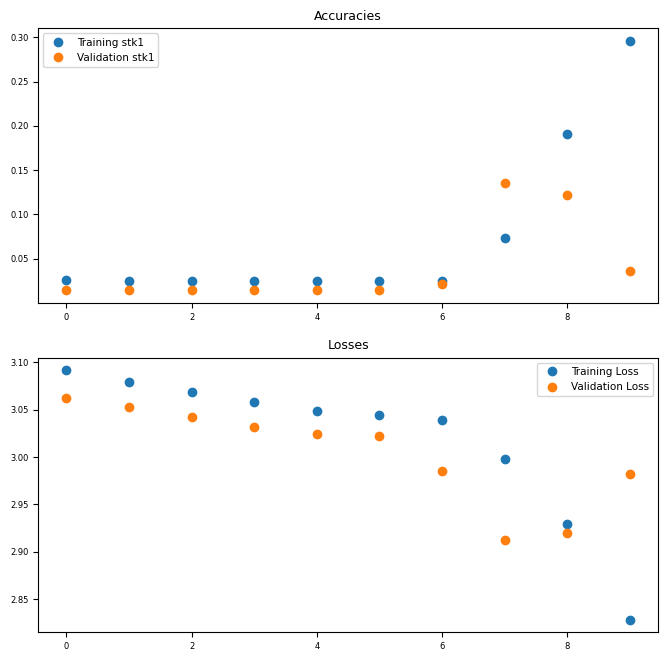

Maximum validation accuracy achieved: 0.13571429252624512


In [19]:
show_histories = 1
accstr = 'stk1'
accstr2 = None

if show_histories:
    epochs = len(history.history['loss'])

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(range(epochs), history.history[accstr], 'o', label='Training '+accstr)
    plt.plot(range(epochs), history.history['val_'+accstr], 'o', label='Validation '+accstr)
    if accstr2 is not None:
        plt.plot(range(epochs), history.history[accstr2], 'x', label='Training '+accstr2)
        plt.plot(range(epochs), history.history['val_'+accstr2], 'x', label='Validation '+accstr2)
    plt.legend()
    plt.title('Accuracies')

    plt.subplot(2, 1, 2)
    plt.plot(range(epochs), history.history['loss'], 'o', label='Training Loss')
    plt.plot(range(epochs), history.history['val_loss'], 'o', label='Validation Loss')
    plt.legend()
    plt.title('Losses')
    plt.show()

    print("Maximum validation accuracy achieved: " + str(np.max(history.history['val_'+accstr])))

### Check predictions of model

In [20]:
## make the predictions
predictions = dp.prediction_to_idx(model.predict(sdd.val_data)) #prediction = type with max probability.
assert len(predictions)==len(sdd.val_data)

prediction (validation data)


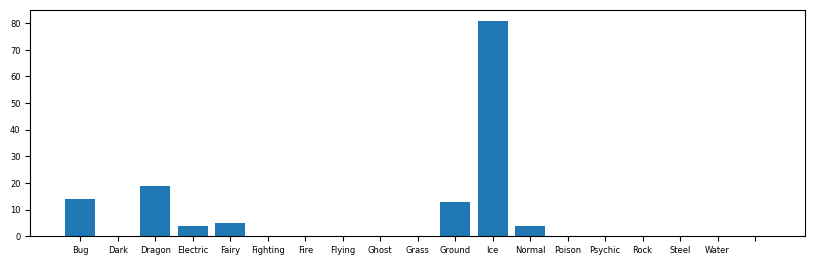

data (validation data)


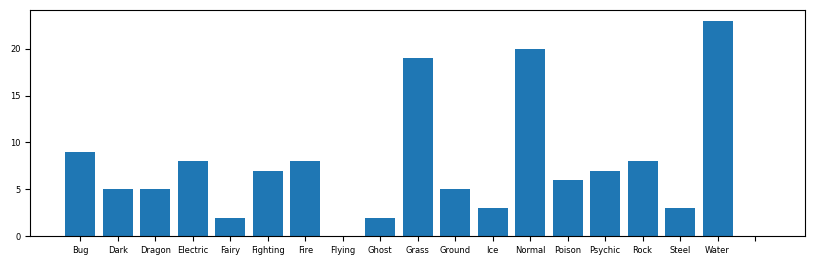

data (train data)


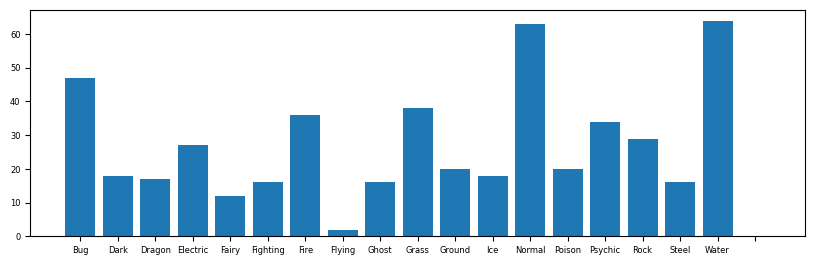

In [21]:
## show distribution of predicted types & distribution of types in the validation dataset
print('prediction (validation data)')
plt.figure(figsize=(10,3))
bc_p = np.bincount(predictions, minlength=dp.NTYPES+1)
plt.bar(dp.ALLTYPES, bc_p);
plt.show()
print('data (validation data)')
plt.figure(figsize=(10,3))
bc_v = np.bincount(sdd.val_labels, minlength=dp.NTYPES+1)
plt.bar(dp.ALLTYPES, bc_v);
plt.show()
print('data (train data)')
plt.figure(figsize=(10,3))
bc_t = np.bincount(sdd.train_labels, minlength=dp.NTYPES+1)
plt.bar(dp.ALLTYPES, bc_t);
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


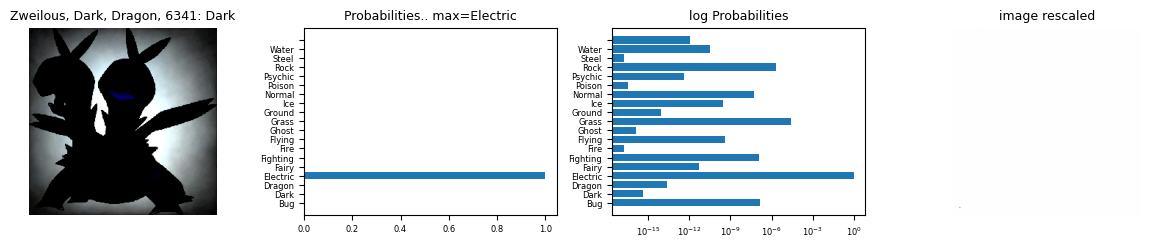

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


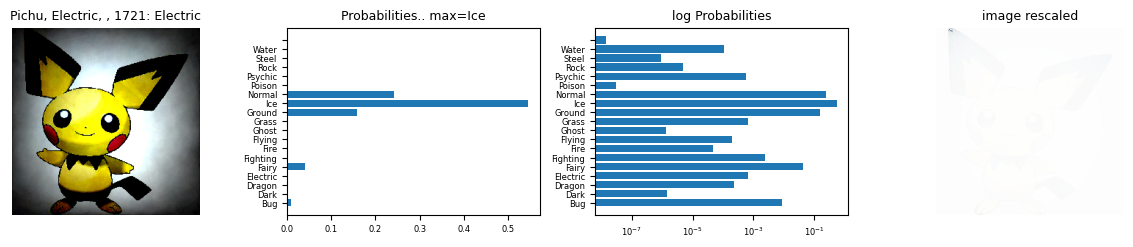

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


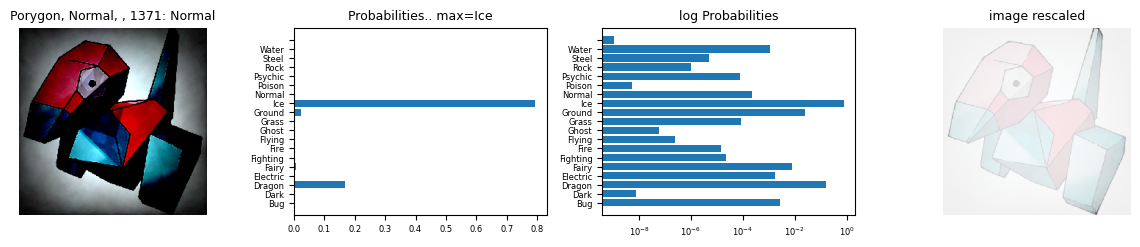

In [23]:
## plot prediction probabilities for some of the pokemon in the test set

istart = 0
istop  = 3
NSAMPLES = istop - istart
slicer = np.s_[istart:istop]

imgs = sdd.val_data[slicer]
lbls = sdd.val_labels[slicer]
nms  = sdd.val_serials[slicer]
predictions = model.predict(imgs)

for i in range(NSAMPLES):
    fig, axs = plt.subplots(1, 4, figsize=[12, 2.5])
    plt.sca(axs[0])
    plt.imshow(imgs[i])
    arr = np.array(lbls[i])
    index = np.where(arr == 1)
    plt.title(', '.join(nms[i])+': '+str(dp.idx_to_type(lbls[i])))
    plt.axis("off")

    plt.sca(axs[1])
    plt.title("Probabilities.. max="+str(dp.idx_to_type(dp.prediction_to_idx(predictions[i]))))
    plt.barh(dp.ALLTYPES, predictions[i])
    
    plt.sca(axs[2])
    plt.title("log Probabilities")
    plt.barh(dp.ALLTYPES, predictions[i])
    plt.xscale('log')
    
    plt.sca(axs[3])
    ip.plt_rescaled(imgs[i])
    plt.title('image rescaled')
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
